# Estudio de Accesibilidad Urbana en Madrid
## Configuración inicial y librerías

En este notebook se utilizan librerías de análisis de redes y datos geoespaciales
para estudiar la accesibilidad urbana en la ciudad de Madrid.

- **OSMnx**: descarga y modelado de redes de calles desde OpenStreetMap.
- **NetworkX**: análisis de grafos (distancias, rutas, conectividad).
- **GeoPandas / Shapely**: manejo de datos espaciales.
- **Matplotlib / Folium / Plotly**: visualización cartográfica.


In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

# Configuración de OSMnx
# use_cache=True evita descargar datos repetidamente
# log_console=True muestra información del proceso en consola
ox.settings.use_cache = True
ox.settings.log_console = True

## Área de estudio y redes de transporte

El área de estudio es la ciudad de Madrid (España). Se descargan tres redes de transporte distintas:

- **Peatonal (walk)**: calles accesibles caminando.
- **Ciclista (bike)**: calles aptas para bicicleta.
- **Automóvil (drive)**: red vial para coches.

Cada red se modela como un grafo dirigido donde los nodos representan intersecciones y las aristas tramos de calle.

In [2]:
city_name = "Madrid, Spain"

# Red peatonal
G_walk = ox.graph_from_place(city_name, network_type='walk')

# Red ciclista
G_bike = ox.graph_from_place(city_name, network_type='bike')

# Red para automóviles
G_drive = ox.graph_from_place(city_name, network_type='drive')

## Barrios de Madrid

Los barrios se obtienen a partir de los límites administrativos de OpenStreetMap.
Se utilizan únicamente geometrías poligonales, necesarias para calcular indicadores de accesibilidad por área.

In [27]:
# Descargar barrios como polígonos administrativos
neighborhoods = ox.features_from_place(
    city_name,
    tags={'boundary': 'administrative', 'admin_level': '10'}
)

# Nos quedamos solo con polígonos
neighborhoods = neighborhoods[neighborhoods.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Filtrar por admin_level 10 (barrios)
neighborhoods = neighborhoods[neighborhoods['admin_level'] == '10']

# Columnas relevantes
neighborhoods = neighborhoods[['name', 'geometry']].dropna()

neighborhoods.head()

name  \
element  id                      
relation 1595612  Pueblo Nuevo   
         1595661        Ventas   
         1600717      Quintana   
         1600733    Concepción   
         1600738   San Pascual   

                                                           geometry  
element  id                                                          
relation 1595612  POLYGON ((-3.6482 40.43309, -3.63803 40.43789,...  
         1595661  POLYGON ((-3.66066 40.43135, -3.6554 40.43214,...  
         1600717  POLYGON ((-3.6554 40.43214, -3.65585 40.43443,...  
         1600733  POLYGON ((-3.66066 40.43135, -3.66064 40.4317,...  
         1600738  POLYGON ((-3.66052 40.44463, -3.65846 40.44535...

In [28]:
len(neighborhoods)

138

In [34]:
# Comprobar duplicados en geometrías de barrios
len(neighborhoods['geometry'].unique())

138

## Destinos clave (POIs)

Se consideran tres tipos de destinos:
- Colegios
- Hospitales
- Supermercados

Cuando un destino está representado como polígono, se utiliza su centroide para los cálculos de accesibilidad.

In [30]:
def ensure_point_geometry(gdf):
    gdf = gdf.copy()
    gdf['geometry'] = gdf.geometry.apply(
        lambda geom: geom.centroid if geom.geom_type != 'Point' else geom
    )
    return gdf


# Colegios
schools = ox.features_from_place(city_name, tags={'amenity': 'school'})
schools = ensure_point_geometry(schools[['geometry']].dropna())
schools['type'] = 'school'

# Hospitales
hospitals = ox.features_from_place(city_name, tags={'amenity': 'hospital'})
hospitals = ensure_point_geometry(hospitals[['geometry']].dropna())
hospitals['type'] = 'hospital'

# Supermercados
supermarkets = ox.features_from_place(city_name, tags={'shop': 'supermarket'})
supermarkets = ensure_point_geometry(supermarkets[['geometry']].dropna())
supermarkets['type'] = 'supermarket'

# Unir todos los destinos
destinations = gpd.GeoDataFrame(
    pd.concat([schools, hospitals, supermarkets], ignore_index=True),
    crs=schools.crs
)

destinations.head()

,geometry,type
0,POINT (-3.75011 40.40752),school
1,POINT (-3.59813 40.44721),school
2,POINT (-3.76221 40.36286),school
3,POINT (-3.65085 40.44344),school
4,POINT (-3.75823 40.37224),school


In [31]:
len(destinations)

2079

## Isochronas de accesibilidad

Una **isocrona** representa el área que puede alcanzarse desde un punto dado en un tiempo determinado, utilizando un modo de transporte específico.

En este proyecto, las isocronas permiten:
- Visualizar qué zonas son accesibles en X minutos.
- Medir cuántos destinos (colegios, hospitales, supermercados) quedan dentro.
- Comparar accesibilidad entre barrios y modos de transporte.

In [32]:
def create_isochrone(G, center_point, travel_speed_kph, travel_minutes):
    """
    Genera una isocrona a partir de un punto central.

    Parametros:
    - G : networkx.Graph
        Grafo de la red de transporte.
    - center_point : shapely.geometry.Point
        Punto de origen.
    - travel_speed_kph : float
        Velocidad media en km/h.
    - travel_minutes : int
        Tiempo máximo de viaje en minutos.

    Devueleve:
    shapely.geometry.Polygon
        Polígono que representa el área accesible.
    """

    speed_m_per_min = travel_speed_kph * 1000 / 60
    center_node = ox.distance.nearest_nodes(G, center_point.x, center_point.y)

    lengths = nx.single_source_dijkstra_path_length(G, center_node, weight='length')
    max_distance = travel_minutes * speed_m_per_min

    reachable_nodes = [n for n, d in lengths.items() if d <= max_distance]
    coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in reachable_nodes]

    if not coords:
        return None

    return MultiPoint(coords).convex_hull

## Metodología de cálculo de la accesibilidad

El análisis de accesibilidad se realiza de forma sistemática considerando la estructura territorial y los distintos modos de transporte disponibles.

El procedimiento seguido es el siguiente:

- **Para cada barrio** de la ciudad de Madrid, utilizando su geometría administrativa.
- **Para cada modo de transporte** analizado:
  - Peatonal
  - Bicicleta
  - Automóvil

Se calcula un indicador de accesibilidad basado en uno de los siguientes criterios:

- **Número de destinos accesibles** (colegios, hospitales y supermercados) dentro de un tiempo máximo de desplazamiento definido.
- **Distancia o tiempo medio** hasta el destino más cercano de cada categoría.

Este enfoque permite comparar de manera objetiva la accesibilidad entre barrios y evaluar cómo varía en función del modo de transporte utilizado.

In [33]:
WALK_SPEED = 4.5  # km/h
TIME = 15  # minutos

results = []

# Calcular accesibilidad peatonal para cada barrio
for idx, row in neighborhoods.iterrows():
    centroid = row.geometry.centroid
    isochrone = create_isochrone(G_walk, centroid, WALK_SPEED, TIME)

    count = 0 if isochrone is None else destinations.within(isochrone).sum()

    results.append({
        'name': row['name'],
        'walk_accessibility': count
    })

# Unir resultados con los barrios
accessibility_walk = neighborhoods.merge(
    pd.DataFrame(results),
    on='name',
    how='left'
)

## Visualización de la accesibilidad

Se representa la accesibilidad mediante un mapa coroplético, donde los colores más intensos indican mayor número de destinos accesibles.

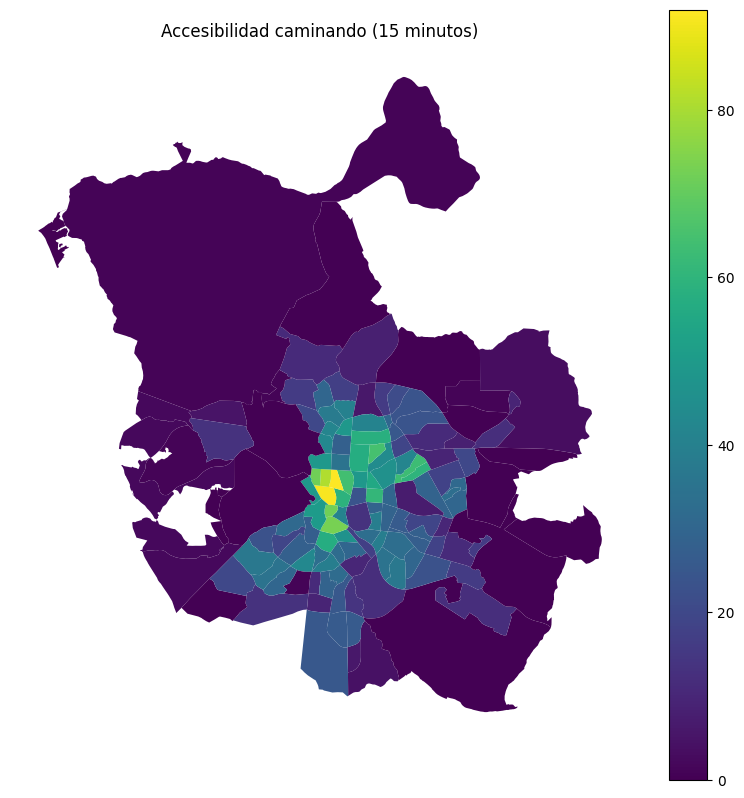

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
accessibility_walk.plot(
    column='walk_accessibility',
    cmap='viridis',
    legend=True,
    ax=ax
)
ax.set_title('Accesibilidad caminando (15 minutos)')
ax.axis('off')
plt.show()

## TODO:
1. Repetir el cálculo para bike y drive
2. Normalizar los resultados (z-score o min-max)
3. Crear un índice combinado de accesibilidad
4. Visualizar:
    - mapas comparativos
    - ranking de barrios